In [52]:
import pandas as pd
import numpy as np
import pickle
import subprocess
import shlex
from collections import defaultdict
from copy import deepcopy
import sklearn
sklearn.__version__

'0.20.1'

In [108]:
def pkl_process(data=None, file=None, mode='dump'):
    f_mode = 'wb' if mode == 'dump' else 'rb'
    load_data = None
    
    with open(file, f_mode) as f:
        if mode == 'dump':
            pickle.dump(data, f)
        else:
            load_data = pickle.load(f)
    
    return load_data

In [3]:
seed = 13

# load categorized data and split train & test sets

## load data

In [7]:
df = pd.read_csv('categorized_NAFLD.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape

(488, 31)

In [8]:
df.head()

,NGT_IFG_,NGT__PRE,DM_STATU,AGE,GNDR,ETHNICIT,BMI,HOMA,SBP,DBP,...,AST_M0,ALT_M0,BILIRRUB,PLATELET,ALBUMIN,TSH,MEAN_FPG,NASH_OU2,FIBROSI2,NAFLD_OU
0,0,0,1,0,0,0,2,2,1,1,...,0,0,0,1,1,0,0,0,0,0
1,1,2,0,2,1,2,3,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,0,0,1,2,1,2,2,0,0,0,...,0,0,0,1,1,0,1,0,0,0
3,0,0,1,1,0,0,3,1,1,1,...,0,0,0,1,1,0,2,0,0,0
4,0,0,1,3,1,0,2,1,1,1,...,0,0,0,1,1,0,2,0,0,0


## split data to train and test set

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)
print('train, test shape: ', train_df.shape, test_df.shape)

train, test shape:  (390, 31) (98, 31)


In [10]:
#get training y label
train_y_nash, train_y_fib, train_y_nafld = np.array(train_df['NASH_OU2']), np.array(train_df['FIBROSI2']), np.array(train_df['NAFLD_OU'])

In [12]:
#build train x data set
train_x = train_df.drop(columns=['NASH_OU2', 'FIBROSI2', 'NAFLD_OU'])
train_x.shape, train_y_nafld.size

((390, 28), 390)

In [13]:
#build test_x data set and test y labels
test_y_nash, test_y_fib, test_y_nafld = np.array(test_df['NASH_OU2']), np.array(test_df['FIBROSI2']), np.array(test_df['NAFLD_OU'])
test_x = test_df.drop(columns=['NASH_OU2', 'FIBROSI2', 'NAFLD_OU'])
test_x.shape, test_y_nafld.size

((98, 28), 98)

# Data Encoding

## One-Hot Encoding

In [15]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, categories='auto')
ohe.fit(df.drop(columns=['NASH_OU2', 'FIBROSI2', 'NAFLD_OU']))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [16]:
#transform data sets based on the encoding result
train_x_ohe = ohe.transform(train_x)
test_x_ohe = ohe.transform(test_x)

In [17]:
train_x_ohe.shape, test_x_ohe.shape

((390, 71), (98, 71))

## Create list of feature names for OHE

In [26]:
# conf_new contains data without MS, conf.pkl contains data with MS
conf = pkl_process(file='conf_new.pkl', mode='load')
print(conf)

{'NGT_IFG_': 'cat', 'NGT__PRE': 'cat', 'DM_STATU': 'cat', 'AGE': [50.0, 60.0, 70.0], 'GNDR': 'cat', 'ETHNICIT': 'cat', 'BMI': [18.5, 24.9, 29.9], 'HOMA': [2.6, 3.8], 'SBP': [130.0], 'DBP': [80.0], 'ON_BP_ME': 'cat', 'CHOL': [200.0], 'TG': [150.0], 'LDL': [100.0, 130.0, 160.0], 'HDL': {'1': [40.0], '0': [50.0]}, 'DYSLIPID': 'cat', 'ON_STATI': 'cat', 'COMBINAT': 'cat', 'A1C': [5.7, 6.5], 'ON_METFO': 'cat', 'ON_SU': 'cat', 'AST_M0': [40.0], 'ALT_M0': [40.0], 'BILIRRUB': [1.0], 'PLATELET': [150.0], 'ALBUMIN': [4.0], 'TSH': [4.0], 'MEAN_FPG': [100.0, 125.0], 'NAFLD_OU': 'outcome', 'NASH_OU2': 'outcome', 'FIBROSI2': 'outcome'}


In [27]:
cat_data_dic = pkl_process(file='cat_dict.pkl', mode='load')
cat_data_dic

{'NGT_IFG_': array(['DIAB', 'IFG', 'IGT', 'NGT'], dtype=object),
 'NGT__PRE': array(['DIAB', 'NGT', 'PreDM'], dtype=object),
 'DM_STATU': array(['0', '1'], dtype=object),
 'GNDR': array(['0', '1'], dtype=object),
 'ETHNICIT': array(['AA', 'Asian', 'Caucasian', 'Hispanic', 'Indian', 'PI'],
       dtype=object),
 'ON_BP_ME': array(['0', '1'], dtype=object),
 'DYSLIPID': array(['0', '1'], dtype=object),
 'ON_STATI': array(['0', '1'], dtype=object),
 'COMBINAT': array(['0', '1'], dtype=object),
 'ON_METFO': array(['0', '1'], dtype=object),
 'ON_SU': array(['0', '1'], dtype=object),
 'NAFLD_OU': array(['0', '1'], dtype=object),
 'NASH_OU2': array(['0', '1'], dtype=object),
 'FIBROSI2': array(['0', '1'], dtype=object)}

## Machine Learning

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Functions

In [29]:
#produce precision & recall & f1 scores of binary cls
def get_binary_cls_precision_recall_f1(true_lab, pred_probs, pos_idx, threshold=0.5):
    pred_lab = []
    for pred in pred_probs:
        pos_prob = pred[pos_idx]
        if pos_prob >= threshold:
            pred_lab.append(1)
        else:
            pred_lab.append(0)
    
    return precision_recall_fscore_support(true_lab, pred_lab, average='binary'), pred_lab

In [50]:
#calculate auc score on test set
def get_auc_roc(classifier, tuned_parameters, train_x, train_y, test_x, test_y, fig=True):
    #use gridsearch due to small data set(400+)
    gs = gs = GridSearchCV(classifier, tuned_parameters, scoring='roc_auc', n_jobs=-1, cv=5, verbose=0, iid=True)
    gs.fit(train_x, train_y)
    print('Best Estimator: ', gs.best_estimator_)
    print('Parameter eval score: ', gs.best_score_)
    clf = gs.best_estimator_
    pred_result_binary = clf.predict_proba(test_x)
    #get all the output=1
    #idx = list(filter(lambda x: x==1, clf.classes_))[0]
    pred_result_1 = list(map(lambda x: x[1], pred_result_binary))
    fpr, tpr, thresholds = roc_curve(test_y, pred_result_1)
    if fig:
        plt.plot(fpr, tpr, lw=1, alpha=0.5)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()
    cut_off = get_cutoff(fpr, tpr, thresholds)
    print('AUC_ROC Score: ', roc_auc_score(test_y, pred_result_1), ' cutoff: ', cut_off)
    return clf, fpr, tpr, thresholds, pred_result_binary, cut_off

In [65]:
#calculate Precision Recall and F1 score on test set
'''
def get_prf(classifier, tuned_parameters, trian_x, train_y, test_x, test_y):
    #use gridsearch due to small data set(400+)
    gs = GridSearchCV(classifier, tuned_parameters, scoring="f1", n_jobs=-1, cv=5, verbose=0, iid=True)
    gs.fit(train_x, train_y)
    print('Best Estimator: ', gs.best_estimator_)
    print('Parameter eval score: ', gs.best_score_)
    clf = gs.best_estimator_
    pred_result = clf.predict(test_x)
    print('PRF Score: ', precision_recall_fscore_support(test_y, pred_result, average='binary'))
    return clf
    '''

def get_prf(classifier, tuned_parameters, train_X, train_y, test_X, test_y):
    gs = GridSearchCV(classifier, tuned_parameters, scoring="f1", n_jobs=-1, cv=5, verbose=0, iid=True)
    gs.fit(train_X, train_y)
#    print(gs.best_score_)
#     print(gs.best_params_)
    print(gs.best_estimator_)
    clf = gs.best_estimator_
    pred_result = clf.predict(test_X)
    print('PRF score: ', precision_recall_fscore_support(test_y, pred_result, average='binary'))
    return clf

In [66]:
#perform 5 fold cross validation
def full_data_set_cv(model, train_x, train_y, test_x, test_y, mode='auc', cv=5, seed=13):
    l1 = list(train_x) + list(test_x)
    l2 = list(train_y) + list(test_y)
    #combine two lists together based on same index
    l = list(zip(l1, l2))
    np.random.seed(seed)
    np.random.shuffle(l)
    X = np.array(list(map(lambda x: x[0], l)))
    y = np.array(list(map(lambda x: x[1], l)))
    
    if mode == 'auc':
        auc = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
        pred_auc = list(map(lambda x: x[1], auc))
        return roc_auc_score(y, pred_auc)
    elif mode == 'prf':
        pred_prf = cross_val_predict(model, X, y, cv=cv, method='predict')
        return precision_recall_fscore_support(y, pred_prf, average='binary')
    else:
        raise ValueError(f'{mode} is not valid!')

In [67]:
def global_jobs(model, tuned_parameters, train_x, train_y, test_x, test_y, model_dict=None, model_name='ML_model', seed=13):
    #auc on test
    clf_auc, fpr, tpr, thresholds, pred_result, cut_off = get_auc_roc(model, tuned_parameters, train_x, train_y, test_x, test_y)
    model_dict[f'{model_name}_auc'] = deepcopy(clf_auc)
    print()
    print('*'*50)
    print()
    
    #PRF on test
    clf_prf = get_prf(model, tuned_parameters, train_x, train_y, test_x, test_y)
    model_dict[f'{model_name}_prf'] = deepcopy(clf_prf)
    print()

In [44]:
# ref: http://www.medicalbiostatistics.com/roccurve.pdf
def get_cutoff(fpr, tpr, thresholds):
    opt_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    return thresholds[opt_idx]

In [45]:
all_models = dict()

## Logistic Regression

In [46]:
tuned_parameters = {'max_iter':[100, 500, 1000], 'tol':[0.00001, 0.0001, 0.001, 0.01, 0.1],'random_state':[seed], 'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 
                    'solver':['lbfgs', 'liblinear', 'newton-cg'], 'class_weight': [None, 'balanced']}

### OHE

#### NAFLD

Best Estimator:  LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=13,
          solver='liblinear', tol=0.001, verbose=0, warm_start=False)
Parameter eval score:  0.861875009048922


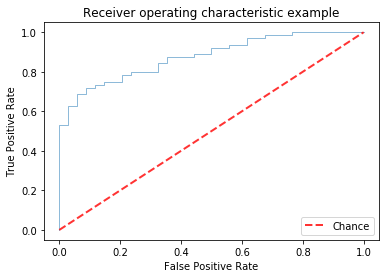

AUC_ROC Score:  0.8772977941176471  cutoff:  0.572892884418034

**************************************************

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='liblinear',
          tol=1e-05, verbose=0, warm_start=False)
PRF score:  (0.8142857142857143, 0.890625, 0.8507462686567163, None)



In [68]:
global_jobs(LogisticRegression(), tuned_parameters, train_x_ohe, train_y_nafld, test_x_ohe, test_y_nafld, model_dict=all_models, model_name='LR_NAFLD_OHE', seed=seed)

#### Nash

Best Estimator:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='liblinear',
          tol=1e-05, verbose=0, warm_start=False)
Parameter eval score:  0.8082510937130502


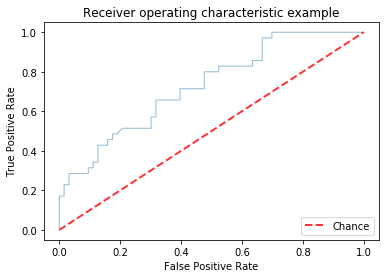

AUC_ROC Score:  0.7281179138321996  cutoff:  0.41339435008437414

**************************************************

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=13,
          solver='liblinear', tol=0.1, verbose=0, warm_start=False)
PRF score:  (0.5263157894736842, 0.5714285714285714, 0.547945205479452, None)



In [69]:
global_jobs(LogisticRegression(), tuned_parameters, train_x_ohe, train_y_nash, test_x_ohe, test_y_nash, model_dict=all_models, model_name='LR_NASH_OHE', seed=seed)

#### Fibrosis

Best Estimator:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=13, solver='liblinear',
          tol=0.1, verbose=0, warm_start=False)
Parameter eval score:  0.7970878236095628


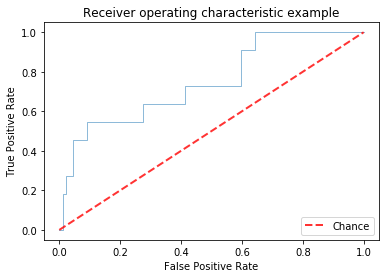

AUC_ROC Score:  0.7492163009404389  cutoff:  0.15645309234040003

**************************************************

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=13,
          solver='lbfgs', tol=1e-05, verbose=0, warm_start=False)
PRF score:  (0.4, 0.5454545454545454, 0.4615384615384615, None)



In [70]:
global_jobs(LogisticRegression(), tuned_parameters, train_x_ohe, train_y_fib, test_x_ohe, test_y_fib, model_dict=all_models, model_name='LR_FIB_OHE', seed=seed)

## SVM

In [73]:
tuned_parameters = {"C": [0.01, 0.1, 2, 64, 128, 512, 1024, 2048], 'probability':[True], 'tol': [0.1, 0.01, 0.001, 0.0001], 
                    'random_state':[seed], 'gamma': ['scale', 'auto']}

### OHE

#### NAFLD

Best Estimator:  SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=13, shrinking=True,
  tol=0.001, verbose=False)
Parameter eval score:  0.8617030433334781


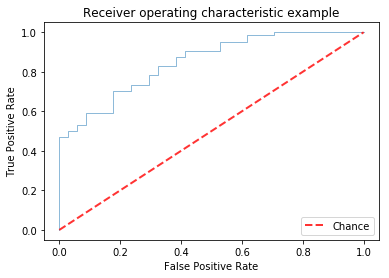

AUC_ROC Score:  0.8501838235294118  cutoff:  0.7937044409211904

**************************************************

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=13, shrinking=True, tol=0.1,
  verbose=False)
PRF score:  (0.7631578947368421, 0.90625, 0.8285714285714286, None)



In [74]:
global_jobs(SVC(), tuned_parameters, train_x_ohe, train_y_nafld, test_x_ohe, test_y_nafld, model_dict=all_models, model_name='SVM_NAFLD_OHE')

#### Nash

Best Estimator:  SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=13, shrinking=True, tol=0.01,
  verbose=False)
Parameter eval score:  0.8138829346981522


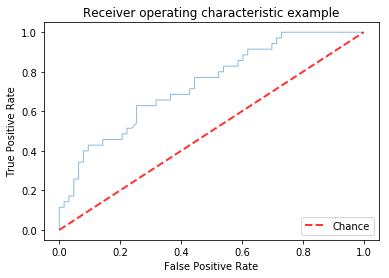

AUC_ROC Score:  0.736281179138322  cutoff:  0.5

**************************************************

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=13, shrinking=True, tol=0.1,
  verbose=False)
PRF score:  (0.5862068965517241, 0.4857142857142857, 0.53125, None)



In [75]:
global_jobs(SVC(), tuned_parameters, train_x_ohe, train_y_nash, test_x_ohe, test_y_nash, model_dict=all_models, model_name='SVM_NASH_OHE')

#### Fibrosis

Best Estimator:  SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=13, shrinking=True, tol=0.1,
  verbose=False)
Parameter eval score:  0.7616592344853215


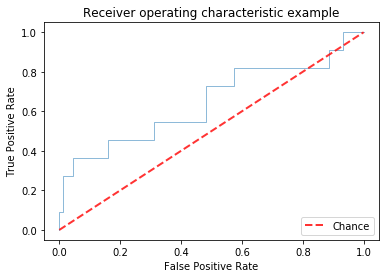

AUC_ROC Score:  0.64576802507837  cutoff:  0.09461842784522848

**************************************************

SVC(C=64, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=13, shrinking=True, tol=0.01,
  verbose=False)
PRF score:  (0.6, 0.2727272727272727, 0.37499999999999994, None)



In [76]:
global_jobs(SVC(), tuned_parameters, train_x_ohe, train_y_fib, test_x_ohe, test_y_fib, model_dict=all_models, model_name='SVM_FIB_OHE')

## Decision Tree with global spliting for tree visualization

In [77]:
%matplotlib inline
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

In [78]:
from sklearn.tree import DecisionTreeClassifier

In [79]:
tuned_parameters = {'criterion':['gini', 'entropy'], 'random_state':[seed], 'max_depth': [5, 10, 25, 50, None],
                    'max_features':['log2', 'auto', None], 'min_samples_split':[2, 4], 'splitter':['best', 'random'],
                    'min_samples_leaf':[1, 2, 4], 'class_weight': [None, 'balanced'], 'min_impurity_decrease': [0., 0.00001, 0.0001, 0.001, 0.01]}#'min_impurity_decrease': [0., 0.0001, 0.001, 0.01]

In [80]:
def draw_decision_tree(clf, class_names=None, feature_names=None, dot_file=None, png_file=None):
    dot = export_graphviz(clf, out_file=dot_file, class_names=class_names, feature_names=feature_names, filled=True)
    p = subprocess.Popen(shlex.split(f"dot -Tpng {dot_file} -o {png_file} -Gdpi=600"), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    o = p.communicate()
    print(o[0].decode('utf8'))
    print(o[1].decode('utf8'))

### OHE

#### NAFLD

Best Estimator:  DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='random')
Parameter eval score:  0.8048781291172595


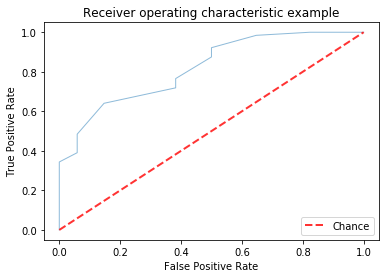

AUC_ROC Score:  0.8193933823529411  cutoff:  0.5984979780473714

**************************************************

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')
PRF score:  (0.8275862068965517, 0.75, 0.7868852459016394, None)



In [81]:
global_jobs(DecisionTreeClassifier(), tuned_parameters, train_x_ohe, train_y_nafld, test_x_ohe, test_y_nafld, model_dict=all_models, model_name='DT_NAFLD_OHE')

#### Nash

Best Estimator:  DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')
Parameter eval score:  0.7767069348726957


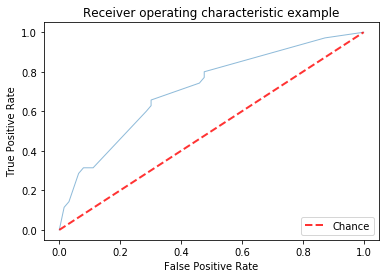

AUC_ROC Score:  0.7138321995464852  cutoff:  0.3577620173364854

**************************************************

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='random')
PRF score:  (0.4722222222222222, 0.4857142857142857, 0.47887323943661975, None)



In [82]:
global_jobs(DecisionTreeClassifier(), tuned_parameters, train_x_ohe, train_y_nash, test_x_ohe, test_y_nash, model_dict=all_models, model_name='DT_NASH_OHE')

#### Fibrosis

Best Estimator:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.001, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='random')
Parameter eval score:  0.7988446419073016


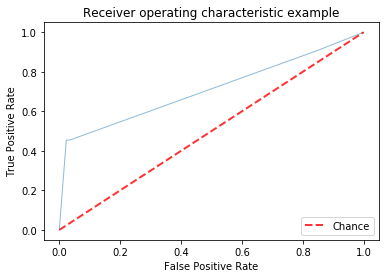

AUC_ROC Score:  0.709508881922675  cutoff:  0.44285714285714284

**************************************************

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.01, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='random')
PRF score:  (0.8333333333333334, 0.45454545454545453, 0.5882352941176471, None)



In [83]:
global_jobs(DecisionTreeClassifier(), tuned_parameters, train_x_ohe, train_y_fib, test_x_ohe, test_y_fib, model_dict=all_models, model_name='DT_FIB_OHE')

### No data transform
only transform string categorical data to OHE

In [84]:
def fc(s):
    return {each:i for i, each in enumerate(s)}

def xys(l):
    return list(zip(*l)) # * unpack a list

In [87]:
df_svm = pd.read_csv('imputed_nafld.csv')
df_svm.head()
df_svm.values

array([['DIAB', 'DIAB', 1, ..., 0, 0, 0],
       ['IFG', 'PreDM', 0, ..., 0, 0, 0],
       ['DIAB', 'DIAB', 1, ..., 0, 0, 0],
       ...,
       ['DIAB', 'DIAB', 1, ..., 1, 0, 1],
       ['DIAB', 'DIAB', 1, ..., 1, 0, 1],
       ['DIAB', 'DIAB', 1, ..., 1, 1, 1]], dtype=object)

In [88]:
d = {0: fc(set(df_svm['NGT_IFG_'])), 1: fc(set(df_svm['NGT__PRE'])), 5: fc(set(df_svm['ETHNICIT']))}
nd = {0: len(set(df_svm['NGT_IFG_'])), 1: len(set(df_svm['NGT__PRE'])), 5: len(set(df_svm['ETHNICIT']))}
print(d)
print(nd)

{0: {'IFG': 0, 'DIAB': 1, 'IGT': 2, 'NGT': 3}, 1: {'DIAB': 0, 'NGT': 1, 'PreDM': 2}, 5: {'Asian': 0, 'Hispanic': 1, 'Indian': 2, 'AA': 3, 'PI': 4, 'Caucasian': 5}}
{0: 4, 1: 3, 5: 6}


In [93]:
#?
n_data = []
for each in df_svm.values:
    n_point = []
    for i, v in enumerate(each):
        if i in d:
            cat = list(np.zeros(shape=nd[i]))
            cat[d[i][v]] = 1
            n_point.extend(cat)
            
        else:
            n_point.append(v)
            
    n_data.append(n_point)

#?
n_data_X = list(map(lambda x: x[:-3], n_data))

In [99]:
n_data_y_nafld = list(map(lambda x: x[-1], n_data))
n_data_y_fib = list(map(lambda x: x[-2], n_data))
n_data_y_nash = list(map(lambda x: x[-3], n_data))

In [100]:
type(n_data_y_nafld)

list

In [112]:
n_data_X = np.array(n_data_X)
data_nafld = list(zip(n_data_X, n_data_y_nafld))
data_nash = list(zip(n_data_X, n_data_y_nash))
data_fib = list(zip(n_data_X, n_data_y_fib))

In [113]:
trs_nafld, tss_nafld = train_test_split(data_nafld, test_size=0.2, random_state=seed)
trs_nash, tss_nash = train_test_split(data_nash, test_size=0.2, random_state=seed)
trs_fib, tss_fib = train_test_split(data_fib, test_size=0.2, random_state=seed)

In [114]:
train_x, train_y = xys(trs_nafld)
test_y, test_y = xys(tss_nafld)

pkl_process(data=train_x, file="data/MIX_train_x_nalfd.pkl", mode="dump")
pkl_process(data=train_y, file="data/MIX_train_y_nalfd.pkl", mode="dump")
pkl_process(data=test_x, file="data/MIX_test_x_nalfd.pkl", mode="dump")
pkl_process(data=test_y, file="data/MIX_test_y_nalfd.pkl", mode="dump")

In [121]:
train_X, train_y = xys(trs_nash)
test_X, test_y = xys(tss_nash)

pkl_process(data=train_X, file="data/MIX_train_x_nash.pkl", mode="dump")
pkl_process(data=train_y, file="data/MIX_train_y_nash.pkl", mode="dump")
pkl_process(data=test_X, file="data/MIX_test_x_nash.pkl", mode="dump")
pkl_process(data=test_y, file="data/MIX_test_y_nash.pkl", mode="dump")

In [122]:
train_X, train_y = xys(trs_fib)
test_X, test_y = xys(tss_fib)

pkl_process(data=train_X, file="data/MIX_train_x_fib.pkl", mode="dump")
pkl_process(data=train_y, file="data/MIX_train_y_fib.pkl", mode="dump")
pkl_process(data=test_X, file="data/MIX_test_x_fib.pkl", mode="dump")
pkl_process(data=test_y, file="data/MIX_test_y_fib.pkl", mode="dump")

#### NAFLD

In [129]:
train_x, train_y = xys(trs_nafld)
test_x, test_y = xys(tss_nafld)

Best Estimator:  DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=25, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.01, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')
Parameter eval score:  0.800824592074592


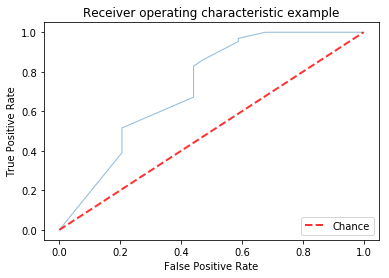

AUC_ROC Score:  0.7217371323529412  cutoff:  0.4017216642754662

**************************************************

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.01, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')
PRF score:  (0.7837837837837838, 0.90625, 0.8405797101449275, None)



In [131]:
global_jobs(DecisionTreeClassifier(), tuned_parameters, train_x, train_y, test_x, test_y, model_dict=all_models, model_name='DT_NAFLD_MIX')

 #### NASH

In [132]:
train_x, train_y = xys(trs_nash)
test_x, test_y = xys(tss_nash)

Best Estimator:  DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.01, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='random')
Parameter eval score:  0.7521342043624653


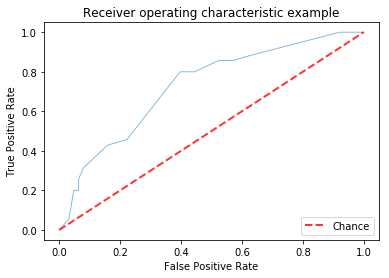

AUC_ROC Score:  0.7267573696145124  cutoff:  0.367816091954023

**************************************************

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.01, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')
PRF score:  (0.5428571428571428, 0.5428571428571428, 0.5428571428571428, None)



In [133]:
global_jobs(DecisionTreeClassifier(), tuned_parameters, train_x, train_y, test_x, test_y, model_dict=all_models, model_name='DT_NASH_MIX')

#### Fibrosis

In [134]:
train_x, train_y = xys(trs_fib)
test_x, test_y = xys(tss_fib)

Best Estimator:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')
Parameter eval score:  0.770109861484542


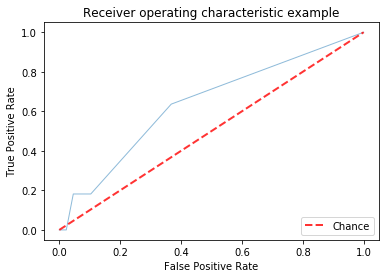

AUC_ROC Score:  0.6379310344827586  cutoff:  0.072992700729927

**************************************************

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=5, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=13,
            splitter='best')
PRF score:  (0.4444444444444444, 0.36363636363636365, 0.39999999999999997, None)



In [135]:
global_jobs(DecisionTreeClassifier(), tuned_parameters, train_x, train_y, test_x, test_y, model_dict=all_models, model_name='DT_FIB_MIX')

## Random Forest

In [136]:
tuned_parameters = {'n_estimators':[10, 50, 100, 500, 1000], 'criterion':['gini', 'entropy'], 'random_state':[seed], 
                    'max_features':['log2', 'auto', None], 'min_samples_split':[2, 4], 'max_depth': [2, 5, 10, 25, 50, None], 
                    'min_samples_leaf':[1,2,4], 'class_weight': [None, 'balanced', 'balanced_subsample']}

### OHE

#### NAFLD

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)
Parameter eval score:  0.8649331827592697


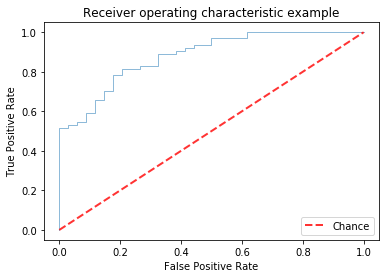

AUC_ROC Score:  0.8814338235294117  cutoff:  0.6300896400680214

**************************************************

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)
PRF score:  (0.7922077922077922, 0.953125, 0.8652482269503546, None)



In [137]:
global_jobs(RandomForestClassifier(), tuned_parameters, train_x_ohe, train_y_nafld, test_x_ohe, test_y_nafld, model_dict=all_models, model_name='RF_NAFLD_OHE')

#### NASH

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)
Parameter eval score:  0.8123934228010316


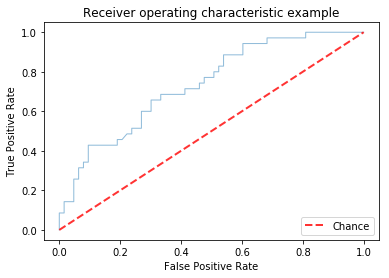

AUC_ROC Score:  0.7353741496598639  cutoff:  0.37557150058878785

**************************************************

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=5, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=13, verbose=0, warm_start=False)
PRF score:  (0.5517241379310345, 0.45714285714285713, 0.5, None)



In [138]:
global_jobs(RandomForestClassifier(), tuned_parameters, train_x_ohe, train_y_nash, test_x_ohe, test_y_nash, model_dict=all_models, model_name='RF_NASH_OHE')

#### Fibrosis

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)
Parameter eval score:  0.8228917743239992


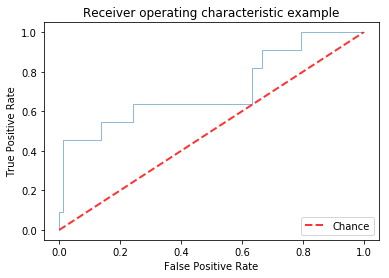

AUC_ROC Score:  0.7136886102403344  cutoff:  0.10552223082633963

**************************************************

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=13, verbose=0, warm_start=False)
PRF score:  (0.8333333333333334, 0.45454545454545453, 0.5882352941176471, None)



In [140]:
global_jobs(RandomForestClassifier(), tuned_parameters, train_x_ohe, train_y_fib, test_x_ohe, test_y_fib, model_dict=all_models, model_name='RF_FIB_OHE')

### No data transformation

#### NAFLD

In [141]:
train_x, train_y = xys(trs_nafld)
test_x, test_y = xys(tss_nafld)

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=13, verbose=0, warm_start=False)
Parameter eval score:  0.9062652926783362


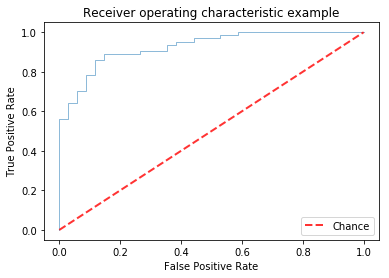

AUC_ROC Score:  0.9278492647058824  cutoff:  0.6259120004406149

**************************************************

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=10, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=13, verbose=0, warm_start=False)
PRF score:  (0.9193548387096774, 0.890625, 0.9047619047619047, None)



In [142]:
global_jobs(RandomForestClassifier(), tuned_parameters, train_x, train_y, test_x, test_y, model_dict=all_models, model_name='RF_NAFLD_MIX')

#### NASH

In [147]:
train_x, train_y = xys(trs_nash)
test_x, test_y = xys(tss_nash)

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=25, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)
Parameter eval score:  0.8270564198281589


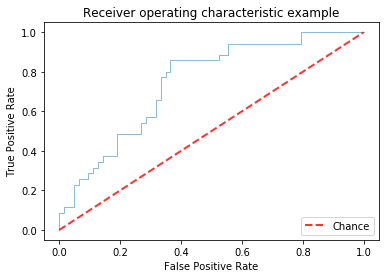

AUC_ROC Score:  0.7451247165532879  cutoff:  0.3226490453990454

**************************************************

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=13, verbose=0, warm_start=False)
PRF score:  (0.53125, 0.4857142857142857, 0.5074626865671641, None)



In [144]:
global_jobs(RandomForestClassifier(), tuned_parameters, train_x, train_y, test_x, test_y, model_dict=all_models, model_name='RF_NASH_MIX')

#### FIB

In [145]:
train_x, train_y = xys(trs_fib)
test_x, test_y = xys(tss_fib)

Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)
Parameter eval score:  0.8557035069694918


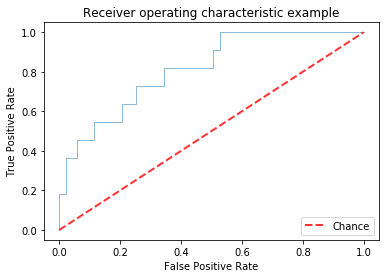

AUC_ROC Score:  0.812957157784744  cutoff:  0.09521220828992838

**************************************************

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=13, verbose=0, warm_start=False)
PRF score:  (0.6666666666666666, 0.36363636363636365, 0.4705882352941177, None)



In [146]:
global_jobs(RandomForestClassifier(), tuned_parameters, train_x, train_y, test_x, test_y, model_dict=all_models, model_name='RF_FIB_MIX')